In [137]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [138]:
# Read in the Reddit data
df = pd.read_csv('../data/redditproject.csv')

# Data Cleaning

In [139]:
df.head()

,title,score,id,url,comms_num,created,body,subreddit
0,When exactly did this whole Force dyad between...,5,jakk3z,https://www.reddit.com/r/saltierthancrait/comm...,9,1.602646e+09,NaN,saltierthancrait
1,"Hol up, can you even jam speeders?",5,jaj49d,https://www.reddit.com/r/saltierthancrait/comm...,10,1.602642e+09,Just thinking about that scene and how massive...,saltierthancrait
2,Remember in Battlefront 2 (newer one) when you...,86,jah2m7,https://www.reddit.com/r/saltierthancrait/comm...,13,1.602636e+09,Because The Rise of Skywalker doesn't seem to,saltierthancrait
3,Just a friendly reminder of how badly Star War...,324,jah1uf,https://i.redd.it/nlzsftux3ws51.png,45,1.602636e+09,NaN,saltierthancrait
4,Dark Empire Episode 1: The Destiny of a Jedi (...,5,jaflwe,https://www.youtube.com/watch?v=lADCO-Ar76U,2,1.602631e+09,NaN,saltierthancrait


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1993 non-null   object 
 1   score      1993 non-null   int64  
 2   id         1993 non-null   object 
 3   url        1993 non-null   object 
 4   comms_num  1993 non-null   int64  
 5   created    1993 non-null   float64
 6   body       817 non-null    object 
 7   subreddit  1993 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 124.7+ KB


In [141]:
# Replace NaN with empty string
df = df.replace(np.nan, '', regex=True)

In [142]:
# Create a text feature category with title and body
df['features'] = df['title'] + ' ' + df['body']

In [143]:
# Recode the target variable with a binary. Our positive class is saltierthancrait
df['target'] = df['subreddit'].map({'StarWarsCantina': 0, 'saltierthancrait': 1})

In [144]:
df.target.value_counts(normalize = True)

1    0.501254
0    0.498746
Name: target, dtype: float64

# EDA - wordcount

In [145]:
df1 = df.copy()

In [146]:
df1.head()

,title,score,id,url,comms_num,created,body,subreddit,features,target
0,When exactly did this whole Force dyad between...,5,jakk3z,https://www.reddit.com/r/saltierthancrait/comm...,9,1.602646e+09,,saltierthancrait,When exactly did this whole Force dyad between...,1
1,"Hol up, can you even jam speeders?",5,jaj49d,https://www.reddit.com/r/saltierthancrait/comm...,10,1.602642e+09,Just thinking about that scene and how massive...,saltierthancrait,"Hol up, can you even jam speeders? Just thinki...",1
2,Remember in Battlefront 2 (newer one) when you...,86,jah2m7,https://www.reddit.com/r/saltierthancrait/comm...,13,1.602636e+09,Because The Rise of Skywalker doesn't seem to,saltierthancrait,Remember in Battlefront 2 (newer one) when you...,1
3,Just a friendly reminder of how badly Star War...,324,jah1uf,https://i.redd.it/nlzsftux3ws51.png,45,1.602636e+09,,saltierthancrait,Just a friendly reminder of how badly Star War...,1
4,Dark Empire Episode 1: The Destiny of a Jedi (...,5,jaflwe,https://www.youtube.com/watch?v=lADCO-Ar76U,2,1.602631e+09,,saltierthancrait,Dark Empire Episode 1: The Destiny of a Jedi (...,1


In [147]:
# Make a new column that cointains the character length of the feature
df1['feature_length'] = df1['features'].str.len()

In [148]:
# Make a new column that containts the word count of the feature
df1['feature_word_count'] = df1['features'].str.split().str.len()

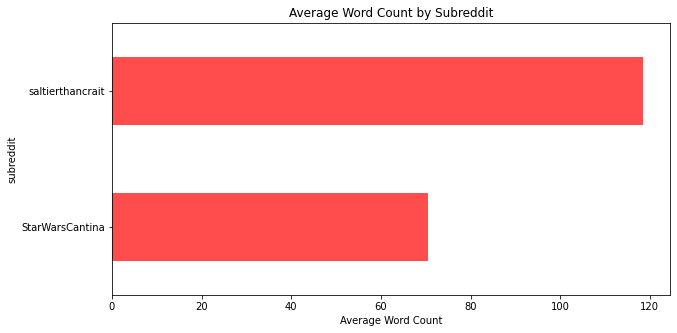

In [151]:
# Plot the average word count for the 2 subreddits
plt.figure(figsize = (10,5))
df1.groupby('subreddit').feature_word_count.mean().plot(kind= 'barh', color = 'red', alpha = .7)
#plt.yticks(rotation = 70)
plt.xlabel('Average Word Count')
plt.title('Average Word Count by Subreddit')

plt.savefig("../figs/word_count.png")

The word count does look pretty different between the two subreddits.  This could make a great feature to model with!

# Count Vectorizer

In [152]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words = 'english', min_df=3)

In [153]:
# Fit CountVectorizer on text features
cvec.fit(df1['features'])

CountVectorizer(min_df=3, stop_words='english')

In [154]:
# Transform the features
feature_transform = cvec.transform(df['features'])

In [155]:
# Create a dataframe with the transformed feature data
feature_transform_df = pd.DataFrame(feature_transform.todense(), 
                          columns=cvec.get_feature_names())


In [156]:
# Look at the top occuring words
feature_transform_df.sum().sort_values(ascending = False).head(15)

star         1000
wars          991
like          836
just          811
luke          724
jedi          656
rey           596
new           550
force         488
movie         438
think         399
people        391
trilogy       377
palpatine     369
time          367
dtype: int64

<AxesSubplot:>

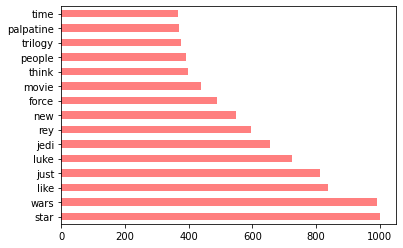

In [157]:
# Plot top occuring words
feature_transform_df.sum().sort_values(ascending = False).head(15).plot(kind= 'barh', color = 'red', alpha = 0.5)

In [158]:
# There is an issue here where 'target' is also one of our text columns, so renaming 'target' to 'tgt'
df1['tgt'] = df1['target']

In [159]:
# Add the target variable to the CountVec transformed data
df_vec = pd.concat([df1['tgt'], feature_transform_df], axis =1)



In [160]:
df_vec.head()

,tgt,00,000,01,09,10,100,1000,1080p,11,...,youth,youtu,youtube,youtuber,youtubers,yt,yup,yuuzhan,zahn,zero
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
# Get a list of all of the word vectors
vec_list = list(feature_transform_df.columns)

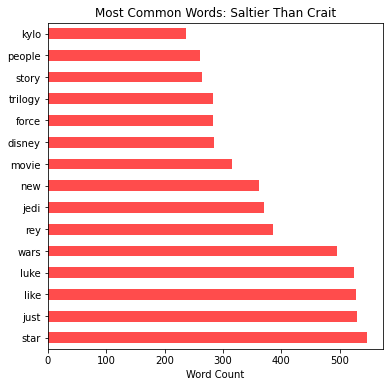

In [162]:
# Plot the most common words for Saltier than Crait
plt.figure(figsize = (6,6))


plt.savefig("../figs/word_count.png")
df_vec[df_vec['tgt'] == 1][vec_list].sum().sort_values(ascending = False).head(15).plot(kind= 'barh', color = 'red', alpha = 0.7)
#plt.yticks(rotation = 70)
plt.xlabel('Word Count')
plt.title('Most Common Words: Saltier Than Crait')
plt.savefig("../figs/salt_words.png")


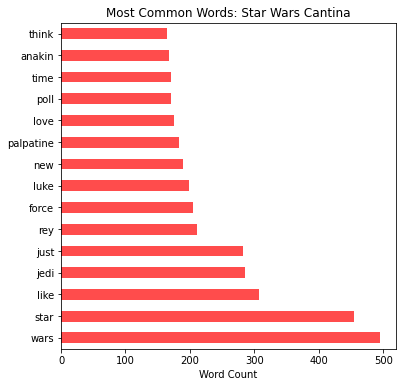

In [163]:
# Plot the most common words for Star Wars Cantina
plt.figure(figsize = (6,6))


plt.savefig("../figs/word_count.png")
df_vec[df_vec['tgt'] == 0][vec_list].sum().sort_values(ascending = False).head(15).plot(kind= 'barh', color = 'red', alpha = 0.7)
#plt.yticks(rotation = 70)
plt.xlabel('Word Count')
plt.title('Most Common Words: Star Wars Cantina')
plt.savefig("../figs/cantina_words.png")

# EDA - sentiment

In [166]:
# Grab the features and target variables
df_temp = df[['features', 'target']]

In [167]:
df_temp.head()

,features,target
0,When exactly did this whole Force dyad between...,1
1,"Hol up, can you even jam speeders? Just thinki...",1
2,Remember in Battlefront 2 (newer one) when you...,1
3,Just a friendly reminder of how badly Star War...,1
4,Dark Empire Episode 1: The Destiny of a Jedi (...,1


In [168]:
# Convert features to a list of strings:

corpus = list(df_temp['features'])
corpus[0]

'When exactly did this whole Force dyad between Rey and Kylo emerge? And why? '

In [169]:
# Instantiate SIA
sia = SentimentIntensityAnalyzer()

# Get polarity scores for the first feature
sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [170]:
# Create dataframe that contains text and the polarity scores for each feature

dicts = []    

for post in corpus:
    scores = sia.polarity_scores(post)
    scores['features'] = post
    dicts.append(scores)

df_vader = pd.DataFrame(dicts)
df_vader.head()

,neg,neu,pos,compound,features
0,0.000,1.000,0.000,0.0000,When exactly did this whole Force dyad between...
1,0.101,0.899,0.000,-0.5574,"Hol up, can you even jam speeders? Just thinki..."
2,0.190,0.810,0.000,-0.7269,Remember in Battlefront 2 (newer one) when you...
3,0.433,0.429,0.137,-0.7845,Just a friendly reminder of how badly Star War...
4,0.000,1.000,0.000,0.0000,Dark Empire Episode 1: The Destiny of a Jedi (...


In [171]:
# Get the subreddit target info into the VADER dataframe
df_vader['target'] = df['target'].values
df_vader.head(5)

,neg,neu,pos,compound,features,target
0,0.000,1.000,0.000,0.0000,When exactly did this whole Force dyad between...,1
1,0.101,0.899,0.000,-0.5574,"Hol up, can you even jam speeders? Just thinki...",1
2,0.190,0.810,0.000,-0.7269,Remember in Battlefront 2 (newer one) when you...,1
3,0.433,0.429,0.137,-0.7845,Just a friendly reminder of how badly Star War...,1
4,0.000,1.000,0.000,0.0000,Dark Empire Episode 1: The Destiny of a Jedi (...,1


In [172]:
# Create a dataframe with just the Saltier Than Crait Vader info
df_stc = df_vader[df_vader['target'] == 1]

In [173]:
# Find the most postivie comments in Saltier Than Crait
df_stc.sort_values(by='pos', ascending=False).head()

,neg,neu,pos,compound,features,target
857,0.0,0.194,0.806,0.8519,What a great love story,1
938,0.0,0.250,0.750,0.7184,Lmao. This aged well.,1
73,0.0,0.286,0.714,0.3612,Y’all agree?,1
746,0.0,0.316,0.684,0.9538,Ahmed Best sharing some black Jedi love today ...,1
656,0.0,0.360,0.640,0.7964,Still a better love story than reylo,1


In [174]:
# Find the most negative comments in Saltier Than Crait
df_stc.sort_values(by='neg', ascending=False).head()


,neg,neu,pos,compound,features,target
533,1.000,0.000,0.0,-0.3612,Ridiculous.,1
178,0.722,0.278,0.0,-0.6369,It *was* a trap :(,1
524,0.674,0.326,0.0,-0.7351,RIP this poor poor cast,1
289,0.669,0.331,0.0,-0.8442,The People Who Killed Star Wars,1
57,0.629,0.371,0.0,-0.5255,I had a goddamn PLAN!,1


In [175]:
# Create a dataframe with just the Star Wars Cantina VADER data
df_swc = df_vader[df_vader['target'] == 0]

In [176]:
# Find the most postive comments in Star Wars Cantina
df_swc.sort_values(by='pos', ascending = False).head()

,neg,neu,pos,compound,features,target
1183,0.0,0.133,0.867,0.7579,Good for a laugh,0
1136,0.0,0.238,0.762,0.4939,Friendly Reminder,0
1404,0.0,0.263,0.737,0.4215,True Jedi,0
1526,0.0,0.263,0.737,0.8555,Ahmed Best is the best.,0
1671,0.0,0.303,0.697,0.3182,PLEASE READ,0


In [177]:
# Find the most negative comments in Star Wars Cantina
df_swc.sort_values(by='neg', ascending = False).head()

,neg,neu,pos,compound,features,target
1497,1.000,0.000,0.0,-0.2244,Badass !,0
1903,0.756,0.244,0.0,-0.4767,Wallpaper accident,0
1047,0.625,0.375,0.0,-0.6124,Hard Star Wars Knowledge Quiz,0
1467,0.621,0.379,0.0,-0.8481,Star Wars #6 Was Wild as Hell,0
1541,0.608,0.392,0.0,-0.8971,There Really Are Things Worse Than Death [Star...,0


In [179]:
# Limit the dataset to only the VADER scores
df_vader.drop(columns=['features', 'target'], inplace = True)
df_vader.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.101,0.899,0.000,-0.5574
2,0.190,0.810,0.000,-0.7269
3,0.433,0.429,0.137,-0.7845
4,0.000,1.000,0.000,0.0000


In [180]:
df1.head()

,title,score,id,url,comms_num,created,body,subreddit,features,target,feature_length,feature_word_count,tgt
0,When exactly did this whole Force dyad between...,5,jakk3z,https://www.reddit.com/r/saltierthancrait/comm...,9,1.602646e+09,,saltierthancrait,When exactly did this whole Force dyad between...,1,77,14,1
1,"Hol up, can you even jam speeders?",5,jaj49d,https://www.reddit.com/r/saltierthancrait/comm...,10,1.602642e+09,Just thinking about that scene and how massive...,saltierthancrait,"Hol up, can you even jam speeders? Just thinki...",1,185,35,1
2,Remember in Battlefront 2 (newer one) when you...,86,jah2m7,https://www.reddit.com/r/saltierthancrait/comm...,13,1.602636e+09,Because The Rise of Skywalker doesn't seem to,saltierthancrait,Remember in Battlefront 2 (newer one) when you...,1,171,30,1
3,Just a friendly reminder of how badly Star War...,324,jah1uf,https://i.redd.it/nlzsftux3ws51.png,45,1.602636e+09,,saltierthancrait,Just a friendly reminder of how badly Star War...,1,85,16,1
4,Dark Empire Episode 1: The Destiny of a Jedi (...,5,jaflwe,https://www.youtube.com/watch?v=lADCO-Ar76U,2,1.602631e+09,,saltierthancrait,Dark Empire Episode 1: The Destiny of a Jedi (...,1,61,11,1


In [181]:
# Add the VADER scores to our dataframe
df2 = pd.concat([df1, df_vader], axis =1)
df2.head(1)

,title,score,id,url,comms_num,created,body,subreddit,features,target,feature_length,feature_word_count,tgt,neg,neu,pos,compound
0,When exactly did this whole Force dyad between...,5,jakk3z,https://www.reddit.com/r/saltierthancrait/comm...,9,1.602646e+09,,saltierthancrait,When exactly did this whole Force dyad between...,1,77,14,1,0.0,1.0,0.0,0.0


<Figure size 720x360 with 0 Axes>

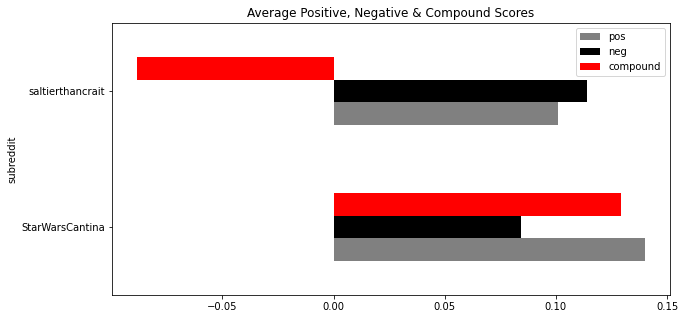

In [182]:
# Plot the VADER scores for the two subreddits
plt.figure(figsize = (10, 5))
df2.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh', color = ['grey', 'black', 'red'], figsize = (10, 5))
plt.title('Average Positive, Negative & Compound Scores')

plt.savefig("../figs/vader.png");

# Data Cleaning

In [183]:
# Get rid of HTML
df2['features'] = df2['features'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('#\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [184]:
# This function is going to remove punctuation and make the text lower case

def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation  #identifies punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) 
   #this iterates through each character, if the character is not a punctuation mark it will join to the empty string

In [185]:
df2['features'] = df2['features'].apply(remove_punctuation)

In [186]:
# Instantiate Porter Stemmer
stemmer = PorterStemmer()  #instantiate stemmer

In [187]:
# This function will stem all the words in our features
def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

In [188]:
# Stemming didn't seem to do much for my models so I'm taking it out for now
#df2['features'] = df['features'].apply(split_and_stem)

In [189]:
df2.head()

,title,score,id,url,comms_num,created,body,subreddit,features,target,feature_length,feature_word_count,tgt,neg,neu,pos,compound
0,When exactly did this whole Force dyad between...,5,jakk3z,https://www.reddit.com/r/saltierthancrait/comm...,9,1.602646e+09,,saltierthancrait,when exactly did this whole force dyad between...,1,77,14,1,0.000,1.000,0.000,0.0000
1,"Hol up, can you even jam speeders?",5,jaj49d,https://www.reddit.com/r/saltierthancrait/comm...,10,1.602642e+09,Just thinking about that scene and how massive...,saltierthancrait,hol up can you even jam speeders just thinking...,1,185,35,1,0.101,0.899,0.000,-0.5574
2,Remember in Battlefront 2 (newer one) when you...,86,jah2m7,https://www.reddit.com/r/saltierthancrait/comm...,13,1.602636e+09,Because The Rise of Skywalker doesn't seem to,saltierthancrait,remember in battlefront 2 newer one when you f...,1,171,30,1,0.190,0.810,0.000,-0.7269
3,Just a friendly reminder of how badly Star War...,324,jah1uf,https://i.redd.it/nlzsftux3ws51.png,45,1.602636e+09,,saltierthancrait,just a friendly reminder of how badly star war...,1,85,16,1,0.433,0.429,0.137,-0.7845
4,Dark Empire Episode 1: The Destiny of a Jedi (...,5,jaflwe,https://www.youtube.com/watch?v=lADCO-Ar76U,2,1.602631e+09,,saltierthancrait,dark empire episode 1 the destiny of a jedi fa...,1,61,11,1,0.000,1.000,0.000,0.0000


In [192]:
# I also tried to get rid of short features, but this made my models worse - perhaps because I'm using word count as a feature
#df2 = df2[df2['feature_word_count'] > 3]
#df2.shape

(1909, 17)

In [193]:
# Save the model training dataset to CSV
df2.to_csv('../data/text_count_sentiment.csv')